
## Overview

We train **personas** to interact with a simple two-step signup flow:

- **Completer**: finish the flow efficiently and correctly.
- **Fuzzer**: explore and poke at the UI to trigger validation banners (e.g., pressing `Next`/`Submit` before filling required inputs).




## Load Data & Compute Metrics



In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
COMPLETER_BASELINE = r"../logs/web_completer_eval.csv"
COMPLETER_DELAY    = r"../logs/web_completer_delay_eval.csv"
FUZZER_CSV         = r"../logs/web_fuzzer_eval.csv"

def _safe_read(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Could not read {path}: {e}")
        return pd.DataFrame()

df_comp_base  = _safe_read(COMPLETER_BASELINE)
df_comp_delay = _safe_read(COMPLETER_DELAY)
df_fuzzer     = _safe_read(FUZZER_CSV)

def compute_metrics(df):
    if df.empty:
        return dict(success_rate=np.nan, median_steps=np.nan, reward_mean=np.nan,
                    val_errors_per_ep=np.nan, status_500_rate=np.nan)
    m = dict()
    m['success_rate'] = float(df['success'].mean()) if 'success' in df else np.nan
    m['median_steps'] = float(df['steps'].median()) if 'steps' in df else np.nan
    m['reward_mean']  = float(df['reward'].mean()) if 'reward' in df else np.nan
    m['val_errors_per_ep'] = float(df['validation_errors'].mean()) if 'validation_errors' in df else np.nan
    return m

metrics_comp_base  = compute_metrics(df_comp_base)
metrics_comp_delay = compute_metrics(df_comp_delay)
metrics_fuzzer     = compute_metrics(df_fuzzer)

summary = pd.DataFrame([
    dict(persona='Completer', condition='Baseline', **metrics_comp_base),
    dict(persona='Completer', condition='Delay',    **metrics_comp_delay),
    dict(persona='Fuzzer',    condition='Baseline (real app)', **metrics_fuzzer),
])
summary


,persona,condition,success_rate,median_steps,reward_mean,val_errors_per_ep
0,Completer,Baseline,1.0,10.0,11.846667,0.0
1,Completer,Delay,0.3,21.0,4.467400,0.0
2,Fuzzer,Baseline (real app),0.0,16.0,0.819333,1.1



## Plots

- **Completer Success Rate** (Baseline vs Delay)
- **Completer Steps (TTC)** via boxplot
- **Fuzzer Validation Errors** distribution and mean


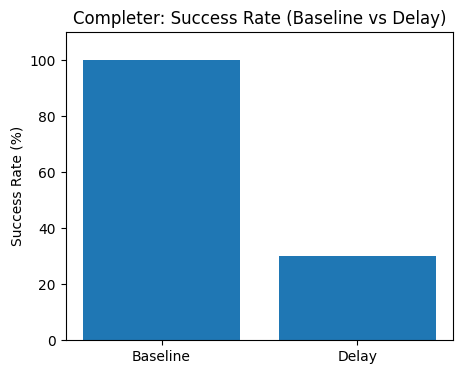

C:\Users\msahi\AppData\Local\Temp\ipykernel_26532\2155439273.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Baseline','Delay'], showmeans=True)


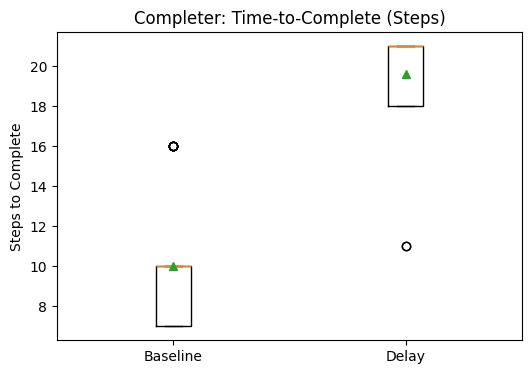

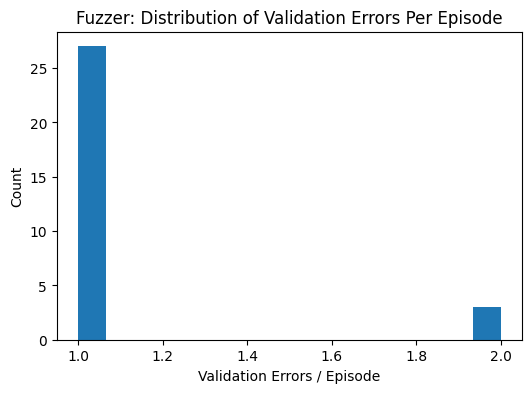

In [8]:

# 1) Success rate (Completer baseline vs delay)
fig1 = plt.figure(figsize=(5,4))
labels = ['Baseline','Delay']
vals = [
    metrics_comp_base.get('success_rate', float('nan'))*100 if metrics_comp_base.get('success_rate') is not None else float('nan'),
    metrics_comp_delay.get('success_rate', float('nan'))*100 if metrics_comp_delay.get('success_rate') is not None else float('nan')
]
plt.bar(labels, vals)
plt.ylabel('Success Rate (%)')
plt.title('Completer: Success Rate (Baseline vs Delay)')
plt.ylim(0, 110)
plt.show()

# 2) Time-to-complete (steps) distribution for Completer
if not df_comp_base.empty and not df_comp_delay.empty and 'steps' in df_comp_base and 'steps' in df_comp_delay:
    fig2 = plt.figure(figsize=(6,4))
    data = [df_comp_base['steps'].dropna().values, df_comp_delay['steps'].dropna().values]
    plt.boxplot(data, labels=['Baseline','Delay'], showmeans=True)
    plt.ylabel('Steps to Complete')
    plt.title('Completer: Time-to-Complete (Steps)')
    plt.show()

# 3) Fuzzer: Validation errors per episode (hist) and mean line
if not df_fuzzer.empty and 'validation_errors' in df_fuzzer:
    fig3 = plt.figure(figsize=(6,4))
    vals = df_fuzzer['validation_errors'].dropna().values
    plt.hist(vals, bins=max(5, min(20, len(vals)//2)) if len(vals)>0 else 5)
    plt.xlabel('Validation Errors / Episode')
    plt.ylabel('Count')
    plt.title('Fuzzer: Distribution of Validation Errors Per Episode')
    plt.show()



## Findings 

**Completer vs Delay**
- *Expectation:* Still has successes, but training in a mock environment causes difficulty with injected delay. Delay increases step count, and may slightly reduce average reward due to living costs and extra steps.
- *Interpretation:* The agent is somewhat robust to moderate latency, completion still exists, but users would experience slower interactions.

**Fuzzer**
- *Purpose:* Stress client-side validation and navigation logic.
- *Behavior:* The naive shaping encourages attempts to advance prematurely, leading to frequent **validation errors**. This is useful to surface where validations appear and whether they’re handled consistently.

